(2, 1024, 1024)
(1024, 1024)


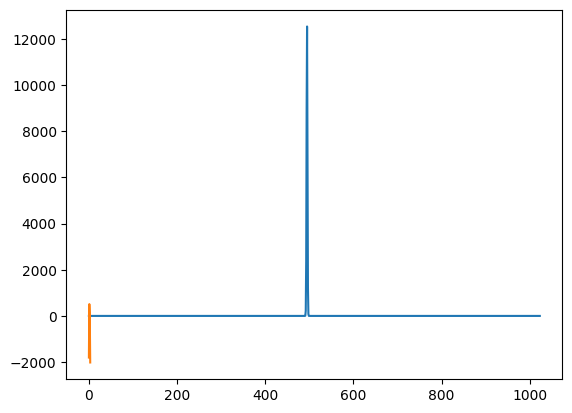


Vertical Fit Results:
Sigma: 7.36, FWHM: 17.33

Horizontal Fit Results:
Sigma: 1.63, FWHM: 3.83
7.361011298608179

Calibration results:
(0.4151, 0.007, -204.40495833324928, -2.4638272906112864, 1.7, 0.87, 3.055555790052255, 0.05152707909025725)


In [47]:
# Import necessary modules
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from pyhdf.SD import SD, SDC

# Define Gaussian function for fitting
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

# Data processing and analysis function
def process_and_calibrate(file_path, EPWgrating, IAWcw, IAWgain, telescope, tstype):
    # Open HDF file and read data
    hdf = SD(file_path, SDC.READ)
    try:
        sds = hdf.select("Streak_array")
        data = sds.get()
        
        # Handle 3D data (time, y, x)
        if data.ndim == 3:
            frame_idx = np.argmax(np.max(data, axis=(1, 2)))
            #data = data[frame_idx, :, :]
            print(data.shape)
            data = data.astype(float)
            data = np.squeeze(data[0,:,:] - data[1,:,:])
        print(data.shape)
        # Find maximum coordinates
        ver_lineout = np.sum(data, axis = 1)
        hor_lineout = np.sum(data, axis = 0)
        # plt.plot(hor_sum)
        # plt.show()
        # plt.plot(ver_sum)
        # # plt.show()
        # y_max, x_max = np.unravel_index(np.argmax(data), data.shape)
        # print(f"Maximum at (y, x): ({y_max}, {x_max})")

        # plt.imshow(data)
        # plt.show()
        # # Extract both lineoust
        # #hor_lineout = data[y_max, :].flatten()
        # # ver_lineout = data[:, x_max].flatten()
        # # plt.plot(ver_lineout)
        # # plt.show()


        # Gaussian fitting for vertical lineout
        x_ver = np.arange(ver_lineout.size)        
        ver_initial_guess = (
            np.max(ver_lineout),
            512,
            1.0,
            np.min(ver_lineout)
        )
        ver_params, _ = curve_fit(gaussian, x_ver, ver_lineout, p0=ver_initial_guess)
        ver_A, mu_ver, sigma_ver, offset_ver = ver_params
        
        fit_A = ver_params[0]
        fit_B = ver_params[1]

        fit_y = gaussian(x_ver, fit_A,fit_B,1,1)
        plt.plot(x_ver, fit_y)
        fwhm_ver = 2.3548 * sigma_ver

        # Gaussian fitting for horizontal lineout
        x_hor = np.arange(hor_lineout.size)
        hor_initial_guess = (
            np.max(hor_lineout),
            512,  # Initial guess for peak position
            1.0,
            np.min(hor_lineout))
        hor_params, _ = curve_fit(gaussian, x_hor, hor_lineout, p0=hor_initial_guess)
        hor_A, mu_hor, sigma_hor, offset_hor = hor_params
        plt.plot(hor_params)
        plt.show()
        fwhm_hor = 2.3548 * sigma_hor

        print(f"\nVertical Fit Results:")
        print(f"Sigma: {sigma_ver:.2f}, FWHM: {fwhm_ver:.2f}")
        print(f"\nHorizontal Fit Results:")
        print(f"Sigma: {sigma_hor:.2f}, FWHM: {fwhm_hor:.2f}")

        # Calibration calculations
        CCDsize = [1024, 1024]
        cali_lw_epw =1
        cali_lw_iaw = 1

        print(sigma_ver)
        return calibrations_table(
            EPWgrating, IAWcw, IAWgain, CCDsize, telescope, tstype, cali_lw_epw, cali_lw_iaw,
            mu_hor, mu_ver, sigma_hor, sigma_ver
        )

    finally:
        hdf.end()

# Calibration function with improved error handling
def calibrations_table(EPWgrating, IAWcw, IAWgain, CCDsize, telescope, tstype, cali_lw_epw, cali_lw_iaw, mu_hor, mu_ver, sigma_hor, sigma_ver):
    # Validate inputs
    if telescope not in ["refractive", "reflective"]:
        raise ValueError("Telescope type must be 'refractive' or 'reflective'")
    
    # Telescope magnifications
    mag_values = {
        "refractive": {"magE": 1.7, "magI": 0.87},
        "reflective": {"magE": 2.3, "magI": 4.5}
    }
    magE = mag_values[telescope]["magE"]
    magI = mag_values[telescope]["magI"]

    # EPW calibration data grating and corresponding disperssions 
    epw_cali = {
        1200: 0.05069,
        600: 0.1019,
        150: 0.4151
    }
    
    # IAW calibration data
    iaw_cali = {
        (1200, 190): 0.004,
        (3600, 263): 0.005,
        (1800, 351): 0.006,
        (600, 527): 0.007
    }

    try:
        EPWDisp = epw_cali[EPWgrating]
        IAWDisp = iaw_cali[(IAWgain, IAWcw)]
    except KeyError as e:
        raise ValueError(f"Invalid calibration parameters: {e}")

    cali_lw_epw = 1
    cali_lw_iaw = 1

    if tstype == " imaging" :
            
        # Calculate offsets
        IAWoff = cali_lw_iaw - IAWDisp * mu_hor
        EPWoff = cali_lw_epw - EPWDisp * mu_hor
        # Calculate standard deviations
        stdev_EPW = sigma_hor * EPWDisp
        stdev_IAW = sigma_hor * IAWDisp

    else: 
        # Calculate offsets
        IAWoff = cali_lw_iaw - IAWDisp * mu_ver
        EPWoff = cali_lw_epw - EPWDisp * mu_ver
        # Calculate standard deviations
        stdev_EPW = sigma_ver * EPWDisp
        stdev_IAW = sigma_ver * IAWDisp
        

    return  EPWDisp, IAWDisp, EPWoff, IAWoff, magE, magI, stdev_EPW, stdev_IAW

if __name__ == "__main__":
    try:
        results = process_and_calibrate(
            file_path="iawross.hdf",
            EPWgrating=150,
            IAWcw=527,
            IAWgain=600,
            telescope="refractive",
            tstype="spectral"
        )
        print("\nCalibration results:")
        print(results)
        #print(f"Calibrated EPW y-axis: {results[0][:5]}...")
       # print(f"Calibrated IAW y-axis: {results[1][:5]}...")
    except Exception as e:
        print(f"Error in processing: {str(e)}")

(2, 1024, 1024)
(1024, 1024)

Vertical Fit Results:
Sigma: 7.36, FWHM: 17.33

Horizontal Fit Results:
Sigma: 3.16, FWHM: 7.45
Error in processing: [Errno 13] Permission denied: 'calibration_results.xlsx'


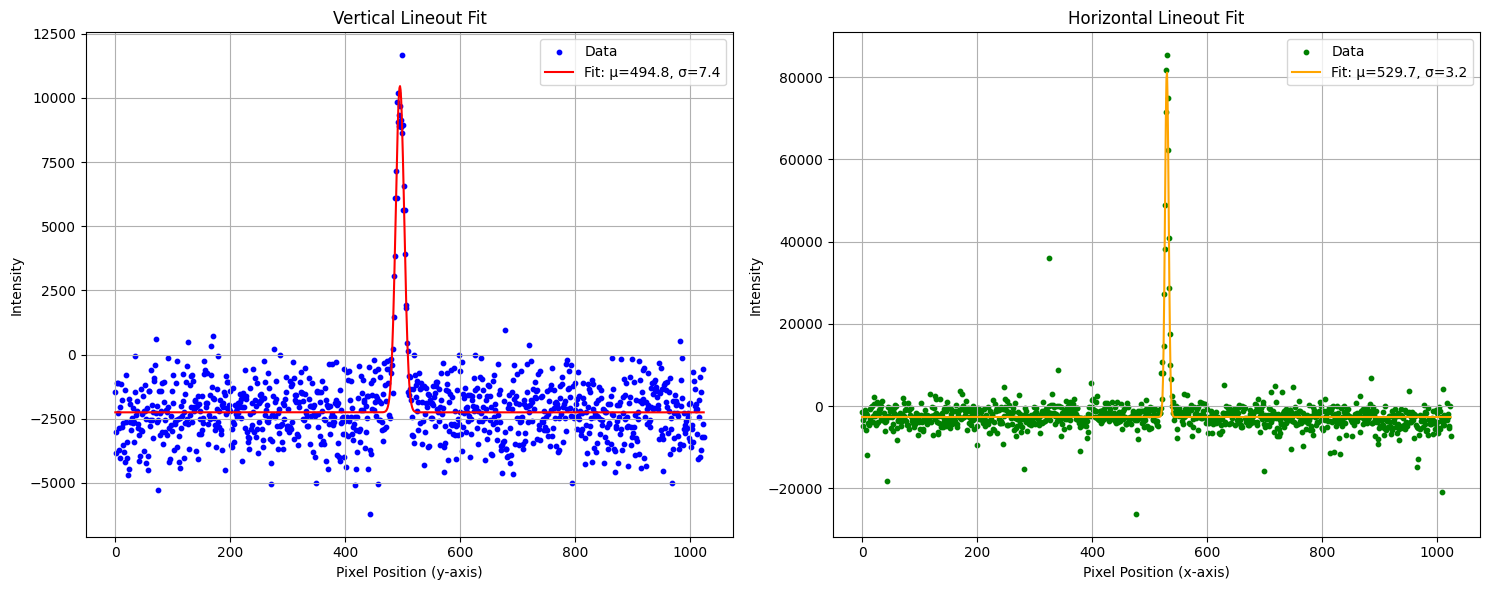

In [ ]:
# Import necessary modules
import numpy as np
from scipy.optimize import curve_fit
from pyhdf.SD import SD, SDC
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt

# Define Gaussian function for fitting
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

def plot_fits(ver_lineout, ver_params, hor_lineout, hor_params):
    """Plot Gaussian fits over the lineout data"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Vertical lineout plot
    x_ver = np.arange(len(ver_lineout))
    ax1.scatter(x_ver, ver_lineout, s=10, label='Data', color='blue')
    ax1.plot(x_ver, gaussian(x_ver, *ver_params), 
            label=f'Fit: μ={ver_params[1]:.1f}, σ={ver_params[2]:.1f}', 
            color='red')
    ax1.set_title('Vertical Lineout Fit')
    ax1.set_xlabel('Pixel Position (y-axis)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax1.grid(True)

    # Horizontal lineout plot
    x_hor = np.arange(len(hor_lineout))
    ax2.scatter(x_hor, hor_lineout, s=10, label='Data', color='green')
    ax2.plot(x_hor, gaussian(x_hor, *hor_params), 
            label=f'Fit: μ={hor_params[1]:.1f}, σ={hor_params[2]:.1f}', 
            color='orange')
    ax2.set_title('Horizontal Lineout Fit')
    ax2.set_xlabel('Pixel Position (x-axis)')
    ax2.set_ylabel('Intensity')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

def process_and_calibrate(file_path, EPWgrating, IAWcw, IAWgain, telescope, tstype):
    """Process data and perform calibrations"""
    hdf = SD(file_path, SDC.READ)
    try:
        sds = hdf.select("Streak_array")
        data = sds.get()

        # Handle 3D data (time, y, x)
        if data.ndim == 3:
            frame_idx = np.argmax(np.max(data, axis=(1, 2)))
            #data = data[frame_idx, :, :]
            print(data.shape)
            data = data.astype(float)
            data = np.squeeze(data[0,:,:] - data[1,:,:])
        print(data.shape)
        # Find maximum coordinates
        ver_lineout = np.sum(data, axis = 1)
        hor_lineout = np.sum(data, axis = 0)
        
        # # Handle 3D data (time, y, x)
        # if data.ndim == 3:
        #     frame_idx = np.argmax(np.max(data, axis=(1, 2)))
        #     data = data[frame_idx, :, :]

        # # Find maximum coordinates
        y_max, x_max = np.unravel_index(np.argmax(data), data.shape)
        # print(f"Maximum at (y, x): ({y_max}, {x_max})")

        # # Extract lineouts
        # ver_lineout = data[:, x_max].flatten()
        # hor_lineout = data[y_max, :].flatten()

        # Vertical fit
        x_ver = np.arange(ver_lineout.size)
        ver_initial_guess = (np.max(ver_lineout), y_max, 1.0, np.min(ver_lineout))
        ver_params, _ = curve_fit(gaussian, x_ver, ver_lineout, p0=ver_initial_guess)
        sigma_ver = ver_params[2]
        fwhm_ver = 2.3548 * sigma_ver

        # Horizontal fit
        x_hor = np.arange(hor_lineout.size)
        hor_initial_guess = (np.max(hor_lineout), x_max, 1.0, np.min(hor_lineout))
        hor_params, _ = curve_fit(gaussian, x_hor, hor_lineout, p0=hor_initial_guess)
        sigma_hor = hor_params[2]
        fwhm_hor = 2.3548 * sigma_hor

        print(f"\nVertical Fit Results:\nSigma: {sigma_ver:.2f}, FWHM: {fwhm_ver:.2f}")
        print(f"\nHorizontal Fit Results:\nSigma: {sigma_hor:.2f}, FWHM: {fwhm_hor:.2f}")

        # Generate plots
        fig = plot_fits(ver_lineout, ver_params, hor_lineout, hor_params)

        # Calibration calculations
        CCDsize = [1024, 1024]
        cali_lw_epw = 1
        cali_lw_iaw = 1
        calibration_results = calibrations_table(
            EPWgrating, IAWcw, IAWgain, CCDsize, telescope, tstype,
            cali_lw_epw, cali_lw_iaw, hor_params[1], ver_params[1],
            sigma_hor, sigma_ver
        )
        
        return calibration_results, fig

    finally:
        hdf.end()

def calibrations_table(EPWgrating, IAWcw, IAWgain, CCDsize, telescope, tstype,
                      cali_lw_epw, cali_lw_iaw, mu_hor, mu_ver, sigma_hor, sigma_ver):
    """Calculate calibration parameters"""
    # Validate inputs
    if telescope not in ["refractive", "reflective"]:
        raise ValueError("Telescope type must be 'refractive' or 'reflective'")

    # Telescope magnifications
    mag_values = {
        "refractive": {"magE": 1.7, "magI": 0.87},
        "reflective": {"magE": 2.3, "magI": 4.5}
    }
    magE = mag_values[telescope]["magE"]
    magI = mag_values[telescope]["magI"]

    # EPW calibration data
    epw_cali = {1200: 0.05069, 600: 0.1019, 150: 0.4151}
    iaw_cali = {
        (1200, 190): 0.004,
        (3600, 263): 0.005,
        (1800, 351): 0.006,
        (600, 527): 0.007
    }

    try:
        EPWDisp = epw_cali[EPWgrating]
        IAWDisp = iaw_cali[(IAWgain, IAWcw)]
    except KeyError as e:
        raise ValueError(f"Invalid calibration parameters: {e}")

    # Calculate offsets and standard deviations
    if tstype == "imaging":
        IAWoff = cali_lw_iaw - IAWDisp * mu_hor
        EPWoff = cali_lw_epw - EPWDisp * mu_hor
        stdev_EPW = sigma_hor * EPWDisp
        stdev_IAW = sigma_hor * IAWDisp
    else:
        IAWoff = cali_lw_iaw - IAWDisp * mu_ver
        EPWoff = cali_lw_epw - EPWDisp * mu_ver
        stdev_EPW = sigma_ver * EPWDisp
        stdev_IAW = sigma_ver * IAWDisp

    return (EPWDisp, IAWDisp, EPWoff, IAWoff, magE, magI, stdev_EPW, stdev_IAW)

def save_to_excel(results, file_path, filename="calibration_results.xlsx"):
    """Save results to Excel with date-based organization"""
    # Get file creation date
    creation_time = os.path.getctime(file_path)
    analysis_date = datetime.fromtimestamp(creation_time).date()
    
    # Create results dictionary
    result_dict = {
        'Analysis Date': [analysis_date.strftime("%Y-%m-%d")],
        'Dispersion EPW': [results[0]],
        'Dispersion IAW': [results[1]],
        'Offset EPW': [results[2]],
        'Offset IAW': [results[3]],
        'Magnification EPW': [results[4]],
        'Magnification IAW': [results[5]],
        'EPW Std Dev (nm)': [results[6]],
        'IAW Std Dev (nm)': [results[7]]
    }
    
    # Update or create Excel file
    try:
        df = pd.read_excel(filename)
        # Remove existing entries for this date
        df = df[df['Analysis Date'] != analysis_date.strftime("%Y-%m-%d")]
    except FileNotFoundError:
        df = pd.DataFrame()

    # Add new results and save
    updated_df = pd.concat([df, pd.DataFrame(result_dict)], ignore_index=True)
    updated_df.to_excel(filename, index=False)
    
    return filename

if __name__ == "__main__":
    try:
        file_path = "iawross.hdf"
        results, fig = process_and_calibrate(
            file_path=file_path,
            EPWgrating=150,
            IAWcw=351,
            IAWgain=1800,
            telescope="refractive",
            tstype="imaging"
        )
        
        # Save data to Excel
        output_file = save_to_excel(results, file_path)
        print(f"\nResults saved to: {output_file}")
        
        # Show interactive plots
        plt.show()
        
    except Exception as e:
        print(f"Error in processing: {str(e)}")

Maximum at (y, x): (626, 655)

Vertical Fit Results:
Sigma: 0.30, FWHM: 0.70

Horizontal Fit Results:
Sigma: 0.33, FWHM: 0.78
Error in processing: [Errno 13] Permission denied: 'calibration_results.xlsx'


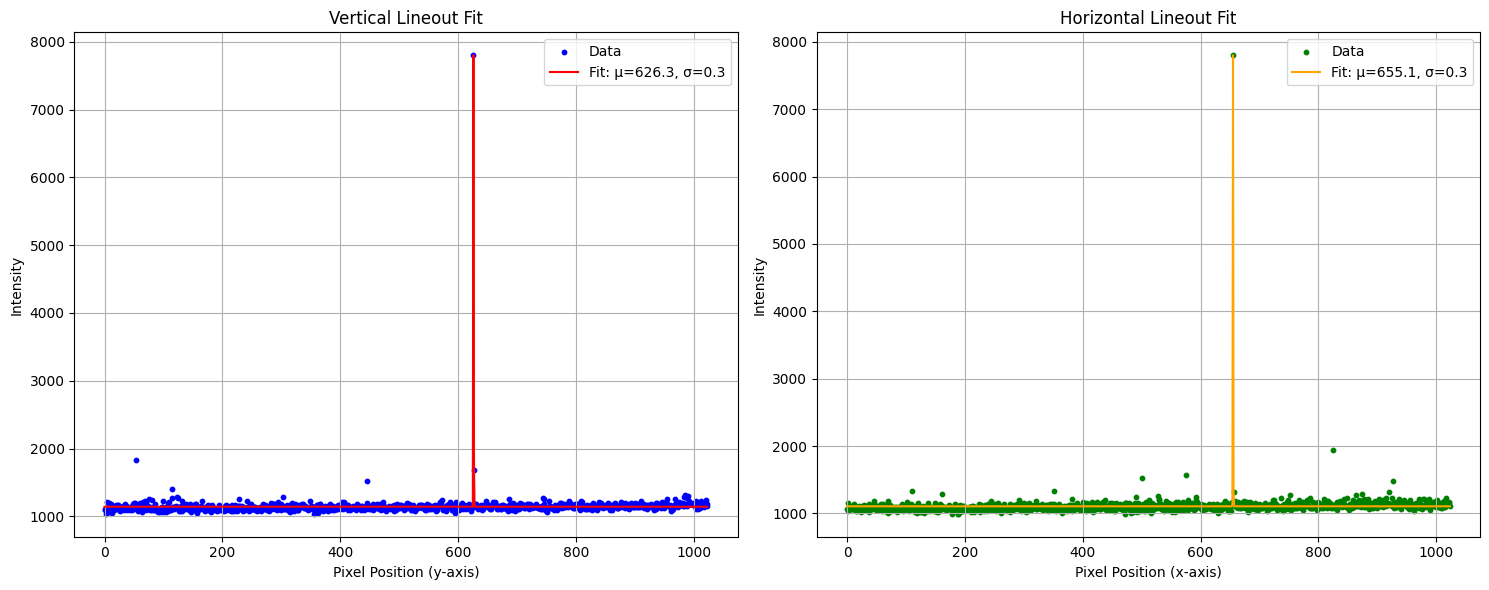

In [46]:
# Import necessary modules
import numpy as np
from scipy.optimize import curve_fit
from pyhdf.SD import SD, SDC
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt

# Define Gaussian function for fitting
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

def plot_fits(ver_lineout, ver_params, hor_lineout, hor_params):
    """Plot Gaussian fits over the lineout data"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Vertical lineout plot
    x_ver = np.arange(len(ver_lineout))
    ax1.scatter(x_ver, ver_lineout, s=10, label='Data', color='blue')
    ax1.plot(x_ver, gaussian(x_ver, *ver_params), 
            label=f'Fit: μ={ver_params[1]:.1f}, σ={ver_params[2]:.1f}', 
            color='red')
    ax1.set_title('Vertical Lineout Fit')
    ax1.set_xlabel('Pixel Position (y-axis)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax1.grid(True)

    # Horizontal lineout plot
    x_hor = np.arange(len(hor_lineout))
    ax2.scatter(x_hor, hor_lineout, s=10, label='Data', color='green')
    ax2.plot(x_hor, gaussian(x_hor, *hor_params), 
            label=f'Fit: μ={hor_params[1]:.1f}, σ={hor_params[2]:.1f}', 
            color='orange')
    ax2.set_title('Horizontal Lineout Fit')
    ax2.set_xlabel('Pixel Position (x-axis)')
    ax2.set_ylabel('Intensity')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

def process_and_calibrate(file_path, EPWgrating, IAWcw, IAWgain, telescope, tstype):
    """Process data and perform calibrations"""
    hdf = SD(file_path, SDC.READ)
    try:
        sds = hdf.select("Streak_array")
        data = sds.get()
        
        # Handle 3D data (time, y, x)
        if data.ndim == 3:
            frame_idx = np.argmax(np.max(data, axis=(1, 2)))
            data = data[frame_idx, :, :]

        # Find maximum coordinates
        y_max, x_max = np.unravel_index(np.argmax(data), data.shape)
        print(f"Maximum at (y, x): ({y_max}, {x_max})")

        # Extract lineouts
        ver_lineout = data[:, x_max].flatten()
        hor_lineout = data[y_max, :].flatten()

        # Vertical fit
        x_ver = np.arange(ver_lineout.size)
        ver_initial_guess = (np.max(ver_lineout), y_max, 1.0, np.min(ver_lineout))
        ver_params, _ = curve_fit(gaussian, x_ver, ver_lineout, p0=ver_initial_guess)
        sigma_ver = ver_params[2]
        fwhm_ver = 2.3548 * sigma_ver

        # Horizontal fit
        x_hor = np.arange(hor_lineout.size)
        hor_initial_guess = (np.max(hor_lineout), x_max, 1.0, np.min(hor_lineout))
        hor_params, _ = curve_fit(gaussian, x_hor, hor_lineout, p0=hor_initial_guess)
        sigma_hor = hor_params[2]
        fwhm_hor = 2.3548 * sigma_hor

        print(f"\nVertical Fit Results:\nSigma: {sigma_ver:.2f}, FWHM: {fwhm_ver:.2f}")
        print(f"\nHorizontal Fit Results:\nSigma: {sigma_hor:.2f}, FWHM: {fwhm_hor:.2f}")

        # Generate plots
        fig = plot_fits(ver_lineout, ver_params, hor_lineout, hor_params)

        # Calibration calculations
        CCDsize = [1024, 1024]
        cali_lw_epw = 1
        cali_lw_iaw = 1
        calibration_results = calibrations_table(
            EPWgrating, IAWcw, IAWgain, CCDsize, telescope, tstype,
            cali_lw_epw, cali_lw_iaw, hor_params[1], ver_params[1],
            sigma_hor, sigma_ver
        )
        
        return calibration_results, fig

    finally:
        hdf.end()

def calibrations_table(EPWgrating, IAWcw, IAWgain, CCDsize, telescope, tstype,
                      cali_lw_epw, cali_lw_iaw, mu_hor, mu_ver, sigma_hor, sigma_ver):
    """Calculate calibration parameters"""
    # Validate inputs
    if telescope not in ["refractive", "reflective"]:
        raise ValueError("Telescope type must be 'refractive' or 'reflective'")

    # Telescope magnifications
    mag_values = {
        "refractive": {"magE": 1.7, "magI": 0.87},
        "reflective": {"magE": 2.3, "magI": 4.5}
    }
    magE = mag_values[telescope]["magE"]
    magI = mag_values[telescope]["magI"]

    # EPW calibration data
    epw_cali = {1200: 0.05069, 600: 0.1019, 150: 0.4151}
    iaw_cali = {
        (1200, 190): 0.004,
        (3600, 263): 0.005,
        (1800, 351): 0.006,
        (600, 527): 0.007
    }

    try:
        EPWDisp = epw_cali[EPWgrating]
        IAWDisp = iaw_cali[(IAWgain, IAWcw)]
    except KeyError as e:
        raise ValueError(f"Invalid calibration parameters: {e}")

    # Calculate offsets and standard deviations
    if tstype == "imaging":
        IAWoff = cali_lw_iaw - IAWDisp * mu_hor
        EPWoff = cali_lw_epw - EPWDisp * mu_hor
        stdev_EPW = sigma_hor * EPWDisp
        stdev_IAW = sigma_hor * IAWDisp
    else:
        IAWoff = cali_lw_iaw - IAWDisp * mu_ver
        EPWoff = cali_lw_epw - EPWDisp * mu_ver
        stdev_EPW = sigma_ver * EPWDisp
        stdev_IAW = sigma_ver * IAWDisp

    return (EPWDisp, IAWDisp, EPWoff, IAWoff, magE, magI, stdev_EPW, stdev_IAW)

def save_to_excel(results, file_path, filename="calibration_results.xlsx"):
    """Save results to Excel with date-based organization"""
    # Get file creation date
    creation_time = os.path.getctime(file_path)
    analysis_date = datetime.fromtimestamp(creation_time).date()
    
    # Create results dictionary
    result_dict = {
        'Analysis Date': [analysis_date.strftime("%Y-%m-%d")],
        'Dispersion EPW': [results[0]],
        'Dispersion IAW': [results[1]],
        'Offset EPW': [results[2]],
        'Offset IAW': [results[3]],
        'Magnification EPW': [results[4]],
        'Magnification IAW': [results[5]],
        'EPW Std Dev (nm)': [results[6]],
        'IAW Std Dev (nm)': [results[7]]
    }
    
    # Update or create Excel file
    try:
        df = pd.read_excel(filename)
        # Remove existing entries for this date
        df = df[df['Analysis Date'] != analysis_date.strftime("%Y-%m-%d")]
    except FileNotFoundError:
        df = pd.DataFrame()

    # Add new results and save
    updated_df = pd.concat([df, pd.DataFrame(result_dict)], ignore_index=True)
    updated_df.to_excel(filename, index=False)
    
    return filename

if __name__ == "__main__":
    try:
        file_path = "iawross.hdf"
        results, fig = process_and_calibrate(
            file_path=file_path,
            EPWgrating=150,
            IAWcw=351,
            IAWgain=1800,
            telescope="refractive",
            tstype="imaging"
        )
        
        # Save data to Excel
        output_file = save_to_excel(results, file_path)
        print(f"\nResults saved to: {output_file}")
        
        # Show interactive plots
        plt.show()
        
    except Exception as e:
        print(f"Error in processing: {str(e)}")

Data shape: (2, 1024, 1024)

Global Statistics (all bands):
Mean: 1101.0368
Standard Deviation: 68.6435


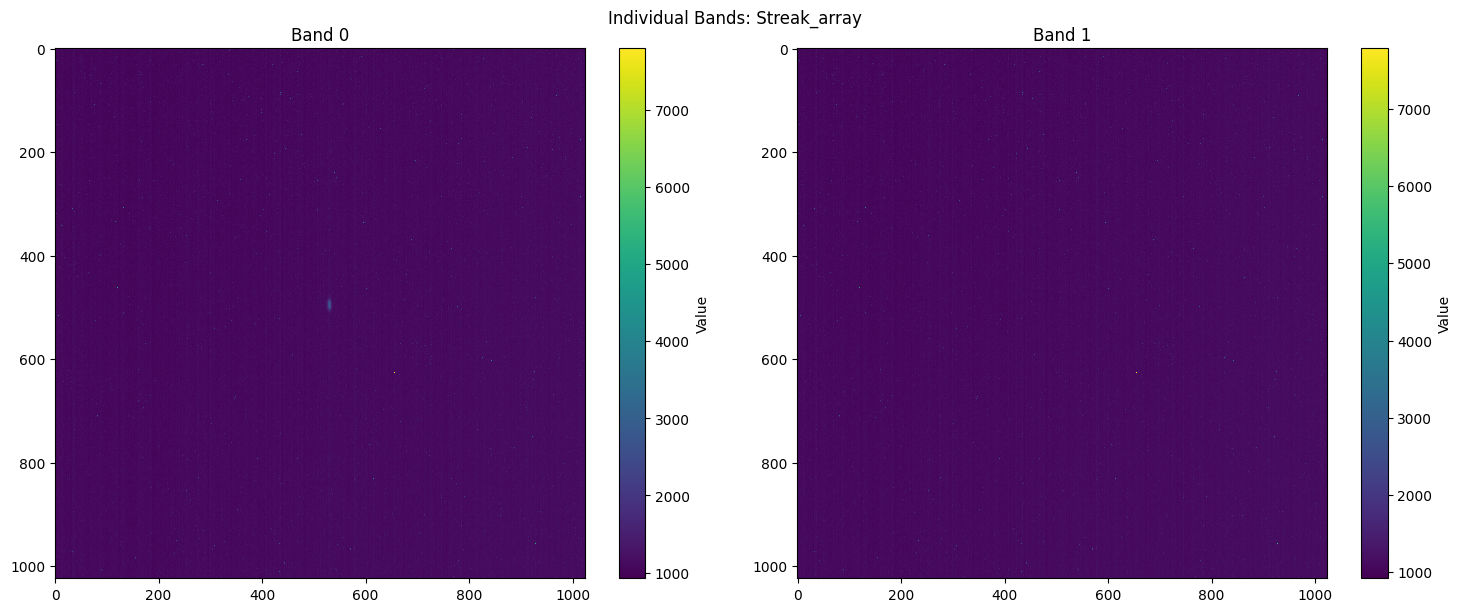

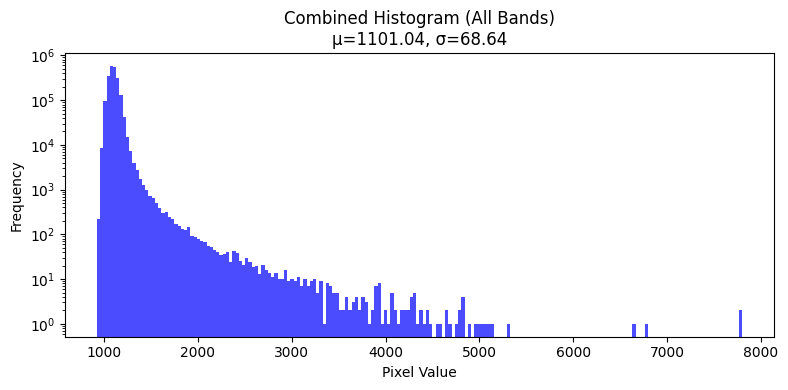

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC

# Open HDF file
filename = 'iawross.hdf'  # Update with your file path
hdf = SD(filename, SDC.READ)

# Get dataset
dataset_name = list(hdf.datasets().keys())[0]
dataset = hdf.select(dataset_name)
data = dataset[:, :].astype(np.float64)
hdf.end()

print(f"Data shape: {data.shape}\n")

# Calculate statistics across ALL bands/pixels
mean = np.nanmean(data)
std_dev = np.nanstd(data)

print(f"Global Statistics (all bands):")
print(f"Mean: {mean:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")

# Visualization setup
plt.figure(figsize=(15, 6))

# Plot each band separately
for i in range(data.shape[0]):
    plt.subplot(1, data.shape[0], i+1)
    plt.imshow(data[i], cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title(f'Band {i}')

plt.suptitle(f'Individual Bands: {dataset_name}')
plt.tight_layout()

# Plot histogram of ALL data
plt.figure(figsize=(8, 4))
plt.hist(data.flatten(), bins=200, color='blue', alpha=0.7)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title(f'Combined Histogram (All Bands)\nμ={mean:.2f}, σ={std_dev:.2f}')
plt.yscale('log')  # Helps visualize skewed distributions
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import os
from datetime import datetime

def save_to_excel(results, file_path, filename="calibration_results.xlsx"):
    """
    Saves calibration results to Excel file organized by analysis date
    - Uses the HDF file's creation date as the primary key
    - Updates existing entries for the same date
    """
    # Get file creation date from the analyzed HDF file
    creation_time = os.path.getctime(file_path)
    analysis_date = datetime.fromtimestamp(creation_time).date()
    
    # Convert results to dictionary with new structure
    result_dict = {
        'Analysis Date': [analysis_date],
        'Dispersion EPW': [results[0]],
        'Dispersion IAW': [results[1]],
        'Offset EPW': [results[2]],
        'Offset IAW': [results[3]],
        'Magnification EPW': [results[4]],
        'Magnification IAW': [results[5]],
        'EPW Std Dev (nm)': [results[6]],
        'IAW Std Dev (nm)': [results[7]]
    }
    
    # Create or update Excel file
    try:
        # Try reading existing file
        df = pd.read_excel(filename)
        
        # Remove existing entries for this date
        df = df[df['Analysis Date'] != analysis_date.strftime("%Y-%m-%d")]
        
    except FileNotFoundError:
        # Create new DataFrame if file doesn't exist
        df = pd.DataFrame(columns=result_dict.keys())
    
    # Add new results and sort by date
    df = pd.concat([df, pd.DataFrame(result_dict)], ignore_index=True)
    df['Analysis Date'] = pd.to_datetime(df['Analysis Date'])
    df = df.sort_values('Analysis Date').drop_duplicates('Analysis Date', keep='last')
    
    # Format dates for readability
    df['Analysis Date'] = df['Analysis Date'].dt.strftime("%Y-%m-%d")
    
    # Save to Excel
    with pd.ExcelWriter(filename, engine='openpyxl', mode='w') as writer:
        df.to_excel(writer, index=False)
    
    return filename

# Modified main execution
if __name__ == "__main__":
    try:
        file_path = "iaw.hdf"
        results = process_and_calibrate(
            file_path=file_path,
            EPWgrating=150,
            IAWcw=351,
            IAWgain=1800,
            telescope="refractive",
            tstype="imaging"
        )
        
        # Save to Excel with file creation date tracking
        output_file = save_to_excel(results, file_path)
        print(f"\nResults saved to: {output_file}")
        
    except Exception as e:
        print(f"Error in processing: {str(e)}")

Maximum at (y, x): (384, 589)

Vertical Fit Results:
Sigma: 1.86, FWHM: 4.39

Horizontal Fit Results:
Sigma: 1.55, FWHM: 3.66

Results saved to: calibration_results.xlsx


In [ ]:
# the working version 
import pandas as pd
from datetime import datetime

#Save results on excel file 
def save_to_excel(results, filename=None):

    # Unpack results
    #axisyE, axisyI, axisxE, axisxI, magE, magI, stdev_EPW, stdev_IAW = results
    EPWDisp, IAWDisp, EPWoff, IAWoff, magE, magI, stdev_EPW, stdev_IAW = results
    
    # Create DataFrames
    summary_data = {
        "Parameter": ["Dispersion EPW", "Dispersion IAW","Offset EPW" , "Offset IAW"
                    ,"Magnification EPW", "Magnification IAW", "EPW Standard Deviation (nm)", "IAW Standard Deviation (nm)"],
        "Value": [EPWDisp, IAWDisp, EPWoff, IAWoff, magE, magI, stdev_EPW, stdev_IAW]
    }
    df_summary = pd.DataFrame(summary_data)


    # Create filename with timestamp
    if not filename:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"Calibration_{timestamp}.xlsx"

    # Write to Excel
    with pd.ExcelWriter(filename) as writer:
        df_summary.to_excel(writer, sheet_name="Summary", index=False)
        
    return filename


if __name__ == "__main__":
    try:
        results = process_and_calibrate(
            file_path="iaw.hdf",
            EPWgrating=150,
            IAWcw=351,
            IAWgain=1800,
            telescope="refractive",
            tstype="imaging"
        )
        
        # Save to Excel
        output_file = save_to_excel(results)
        print(f"\nResults saved to: {output_file}")
        
    except Exception as e:
        print(f"Error in processing: {str(e)}")

(2, 1024, 1024)
(1024, 1024)

Vertical Fit Results:
Sigma: 7.36, FWHM: 17.33

Horizontal Fit Results:
Sigma: 3.16, FWHM: 7.45

Results saved to: calibration_results.xlsx


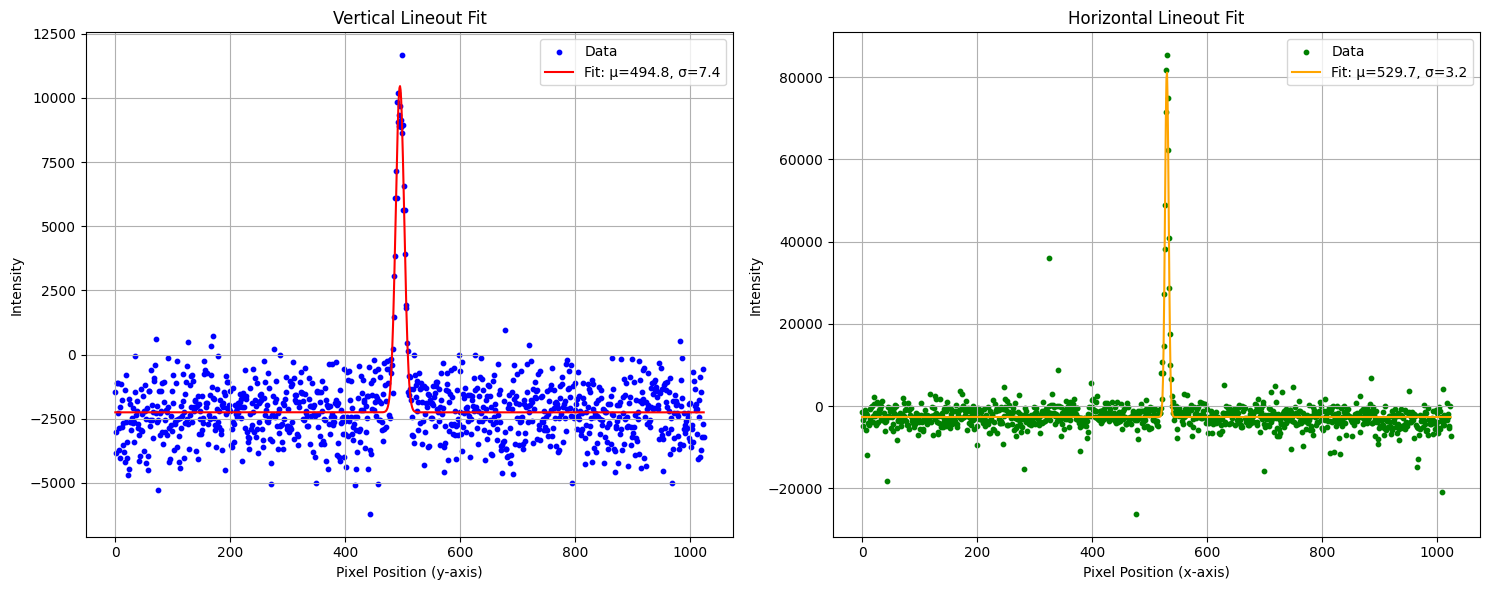

In [8]:
# Import necessary modules
import numpy as np
from scipy.optimize import curve_fit
from pyhdf.SD import SD, SDC
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt

# Define Gaussian function for fitting
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

def plot_fits(ver_lineout, ver_params, hor_lineout, hor_params):
    """Plot Gaussian fits over the lineout data"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Vertical lineout plot
    x_ver = np.arange(len(ver_lineout))
    ax1.scatter(x_ver, ver_lineout, s=10, label='Data', color='blue')
    ax1.plot(x_ver, gaussian(x_ver, *ver_params), 
            label=f'Fit: μ={ver_params[1]:.1f}, σ={ver_params[2]:.1f}', 
            color='red')
    ax1.set_title('Vertical Lineout Fit')
    ax1.set_xlabel('Pixel Position (y-axis)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax1.grid(True)

    # Horizontal lineout plot
    x_hor = np.arange(len(hor_lineout))
    ax2.scatter(x_hor, hor_lineout, s=10, label='Data', color='green')
    ax2.plot(x_hor, gaussian(x_hor, *hor_params), 
            label=f'Fit: μ={hor_params[1]:.1f}, σ={hor_params[2]:.1f}', 
            color='orange')
    ax2.set_title('Horizontal Lineout Fit')
    ax2.set_xlabel('Pixel Position (x-axis)')
    ax2.set_ylabel('Intensity')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

def process_and_calibrate(file_path, EPWgrating,EPWcw, IAWcw, IAWgrating, telescope, tstype):
    """Process data and perform calibrations"""
    hdf = SD(file_path, SDC.READ)
    try:
        sds = hdf.select("Streak_array")
        data = sds.get()

                
        # Handle 3D data (time, y, x)
        if data.ndim == 3:
            frame_idx = np.argmax(np.max(data, axis=(1, 2)))
            #data = data[frame_idx, :, :]
            print(data.shape)
            data = data.astype(float)
            data = np.squeeze(data[0,:,:] - data[1,:,:])
        print(data.shape)
        # Find maximum coordinates
        ver_lineout = np.sum(data, axis = 1)
        hor_lineout = np.sum(data, axis = 0)
        
        # # Handle 3D data (time, y, x)
        # if data.ndim == 3:
        #     frame_idx = np.argmax(np.max(data, axis=(1, 2)))
        #     data = data[frame_idx, :, :]

        # # Find maximum coordinates
        y_max, x_max = np.unravel_index(np.argmax(data), data.shape)
        # print(f"Maximum at (y, x): ({y_max}, {x_max})")

        # # Extract lineouts
        # ver_lineout = data[:, x_max].flatten()
        # hor_lineout = data[y_max, :].flatten()

        # Vertical fit
        x_ver = np.arange(ver_lineout.size)
        ver_initial_guess = (np.max(ver_lineout), y_max, 1.0, np.min(ver_lineout))
        ver_params, _ = curve_fit(gaussian, x_ver, ver_lineout, p0=ver_initial_guess)
        sigma_ver = ver_params[2]
        fwhm_ver = 2.3548 * sigma_ver

        # Horizontal fit
        x_hor = np.arange(hor_lineout.size)
        hor_initial_guess = (np.max(hor_lineout), x_max, 1.0, np.min(hor_lineout))
        hor_params, _ = curve_fit(gaussian, x_hor, hor_lineout, p0=hor_initial_guess)
        sigma_hor = hor_params[2]
        fwhm_hor = 2.3548 * sigma_hor

        print(f"\nVertical Fit Results:\nSigma: {sigma_ver:.2f}, FWHM: {fwhm_ver:.2f}")
        print(f"\nHorizontal Fit Results:\nSigma: {sigma_hor:.2f}, FWHM: {fwhm_hor:.2f}")

        # Generate plots
        fig = plot_fits(ver_lineout, ver_params, hor_lineout, hor_params)

        # Calibration calculations
        CCDsize = [1024, 1024]
        cali_lw_epw = 1
        cali_lw_iaw = 1
        calibration_results = calibrations_table(
            EPWgrating, EPWcw, IAWcw, IAWgrating, CCDsize, telescope, tstype,
            cali_lw_epw, cali_lw_iaw, hor_params[1], ver_params[1],
            sigma_hor, sigma_ver
        )
        
        return calibration_results, fig

    finally:
        hdf.end()

def calibrations_table(EPWgrating,EPWcw, IAWcw, IAWgrating, CCDsize, telescope, tstype,
                      cali_lw_epw, cali_lw_iaw, mu_hor, mu_ver, sigma_hor, sigma_ver):
    """Calculate calibration parameters"""
    # Validate inputs
    if telescope not in ["refractive", "reflective"]:
        raise ValueError("Telescope type must be 'refractive' or 'reflective'")

    # Telescope magnifications
    mag_values = {
        "refractive": {"magE": 1.7, "magI": 0.87},
        "reflective": {"magE": 2.3, "magI": 4.5}
    }
    magE = mag_values[telescope]["magE"]
    magI = mag_values[telescope]["magI"]

    # EPW calibration data from Joe's file (grating (g/nm), central wavelenght (nm)) : dispersion (nm/px)
    epw_cali = {
        (150,263): 0.4156,
        (150,351) : 0.4153,
        (150,527): 0.4143, 
        (600,320): 0.1019,
        (1200,190): 0.05069
    }
    # IAW calibrations from Julie's file (grating (g/nm), central wavelenght (nm)) : dispersion (nm/px)
    iaw_cali = {
        (3600,265): 0.00444,
        (3600,365.5): 0.00352,
        (2400,365): 0.00692,
        (2400,522): 0.00567, 
        (2400,520): 0.00574, 
        (2160,521): 0.00681,
        (2160,520): 0.00688,
        (2160,523):0.00687,
        (1800,525): 0.00890
    }

    try:
        EPWDisp = epw_cali[(EPWgrating,EPWcw)]
        IAWDisp = iaw_cali[(IAWgrating, IAWcw)]
    except KeyError as e:
        raise ValueError(f"Invalid calibration parameters: {e}")

    # Calculate offsets and standard deviations
    if tstype == "imaging":
        IAWoff = cali_lw_iaw - IAWDisp * mu_hor
        EPWoff = cali_lw_epw - EPWDisp * mu_hor
        stdev_EPW = sigma_hor * EPWDisp
        stdev_IAW = sigma_hor * IAWDisp
    else:
        IAWoff = cali_lw_iaw - IAWDisp * mu_ver
        EPWoff = cali_lw_epw - EPWDisp * mu_ver
        stdev_EPW = sigma_ver * EPWDisp
        stdev_IAW = sigma_ver * IAWDisp

    return (EPWDisp, IAWDisp, EPWoff, IAWoff, magE, magI, stdev_EPW, stdev_IAW)

def save_to_excel(results, file_path, filename="calibration_results.xlsx"):
    """Save results to Excel with date-based organization"""
    # Get file creation date
    creation_time = os.path.getctime(file_path)
    analysis_date = datetime.fromtimestamp(creation_time).date()
    
    # Create results dictionary
    result_dict = {
        'Analysis Date': [analysis_date.strftime("%Y-%m-%d")],
        'Dispersion EPW': [results[0]],
        'Dispersion IAW': [results[1]],
        'Offset EPW': [results[2]],
        'Offset IAW': [results[3]],
        'Magnification EPW': [results[4]],
        'Magnification IAW': [results[5]],
        'EPW Std Dev (nm)': [results[6]],
        'IAW Std Dev (nm)': [results[7]]
    }
    
    # Update or create Excel file
    try:
        df = pd.read_excel(filename)
        # Remove existing entries for this date
        df = df[df['Analysis Date'] != analysis_date.strftime("%Y-%m-%d")]
    except FileNotFoundError:
        df = pd.DataFrame()

    # Add new results and save
    updated_df = pd.concat([df, pd.DataFrame(result_dict)], ignore_index=True)
    updated_df.to_excel(filename, index=False)
    
    return filename

if __name__ == "__main__":
    try:
        file_path = "iawross.hdf"
        results, fig = process_and_calibrate(
            file_path=file_path,
            EPWgrating=150,
            EPWcw = 263,
            IAWcw=525,
            IAWgrating=1800,
            telescope="refractive",
            tstype="imaging"
        )
        
        # Save data to Excel
        output_file = save_to_excel(results, file_path)
        print(f"\nResults saved to: {output_file}")
        
        # Show interactive plots
        plt.show()
        
    except Exception as e:
        print(f"Error in processing: {str(e)}")

In [5]:
pip install pandas openpyxl xlrd

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import pandas as pd
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Configuration
FOLDER_PATH = "historic/data"  # Replace with your folder path
OUTPUT_FILE = "analysis_results.xlsx"

def read_files(folder_path):
    """Read all CSV, Excel, and JSON files from a folder into DataFrames."""
    dataframes = []
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        try:
            if filename.endswith('.csv'):
                df = pd.read_csv(file_path)
            elif filename.endswith(('.xls', '.xlsx')):
                df = pd.read_excel(file_path)
            elif filename.endswith('.json'):
                df = pd.read_json(file_path)
            else:
                continue  # Skip unsupported formats
            
            df['source_file'] = filename  # Track source file
            dataframes.append(df)
            
        except Exception as e:
            print(f"Error reading {filename}: {str(e)}")
    
    return pd.concat(dataframes, ignore_index=True) if dataframes else None

def analyze_data(df):
    """Perform data analysis (customize this based on your needs)."""
    analysis = {}
    
    # Example analysis 1: Basic statistics
    analysis['summary_stats'] = df.describe(include='all')
    
    # Example analysis 2: Count by category (modify column name)
    if 'category_column' in df.columns:
        analysis['category_counts'] = df['category_column'].value_counts().reset_index()
        analysis['category_counts'].columns = ['Category', 'Count']
    
    return analysis

def save_to_excel(results, analysis, output_file):
    """Save data and analysis to Excel with formatting."""
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # Save raw combined data
        results.to_excel(writer, sheet_name='Raw Data', index=False)
        
        # Save analysis sheets
        for sheet_name, df in analysis.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Auto-adjust column widths
        workbook = writer.book
        for sheetname in writer.sheets:
            sheet = workbook[sheetname]
            for column in sheet.columns:
                max_length = max(len(str(cell.value)) for cell in column)
                sheet.column_dimensions[column[0].column_letter].width = max_length + 2

# Main execution
if __name__ == "__main__":
    if not os.path.exists(FOLDER_PATH):
        print(f"Error: Folder {FOLDER_PATH} does not exist!")
    else:
        combined_data = read_files(FOLDER_PATH)
        if combined_data is not None:
            analysis_results = analyze_data(combined_data)
            save_to_excel(combined_data, analysis_results, OUTPUT_FILE)
            print(f"Analysis saved to {OUTPUT_FILE}")
        else:
            print("No readable files found in the folder!")